In [52]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from astropy import units, constants

from utils.plot_utils import set_fontsize

In [4]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [10]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [11]:
np.random.seed(42)
size = int(1e8)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

In [12]:
in_to_m = (units.imperial.inch).to(units.m)

In [13]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

In [14]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [15]:
distance_aperture_2 = 31 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [16]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [17]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

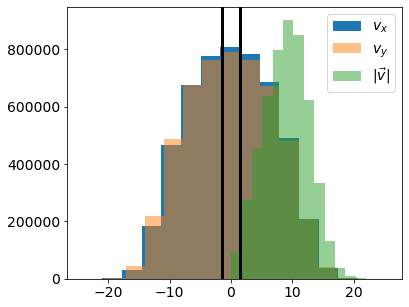

In [24]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

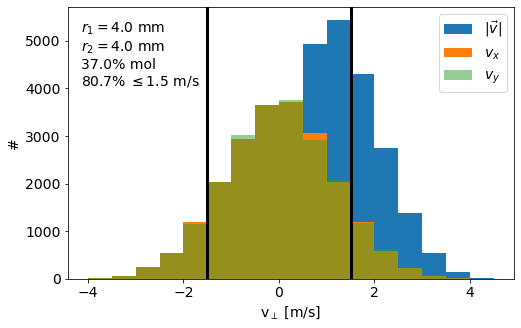

In [25]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

In [40]:
v_zf = v_z[m]
v_xf = v_x[m]

In [31]:
from scipy.spatial.transform import Rotation

In [133]:
r = Rotation.from_euler('z', 0, degrees = True)

In [134]:
vt = r.as_matrix()[:2,:2] @ np.vstack([v_zf, v_xf])

(array([  11.,  166.,  981., 3473., 6198., 6294., 3365.,  968.,  154.,
          15.]),
 array([119.91977937, 133.3810392 , 146.84229903, 160.30355886,
        173.76481869, 187.22607852, 200.68733835, 214.14859817,
        227.609858  , 241.07111783, 254.53237766]),
 <BarContainer object of 10 artists>)

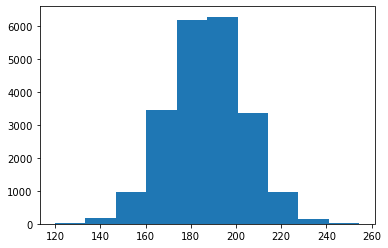

In [135]:
plt.hist(vt[0])

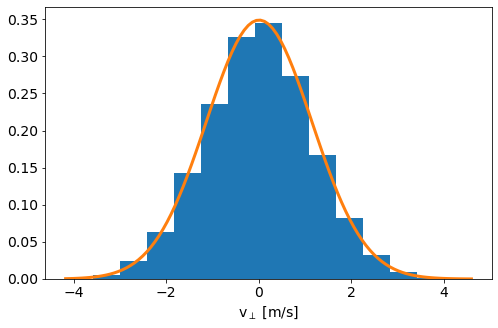

In [136]:
mu, sigma = norm.fit(vt[1])

fig, ax = plt.subplots(figsize = (8,5))
h = ax.hist(vt[1], bins = 15, density = True);

_x = np.linspace(vt[1].min(), vt[1].max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.set_xlabel(r'v$_\perp$ [m/s]')
set_fontsize(ax, 14)

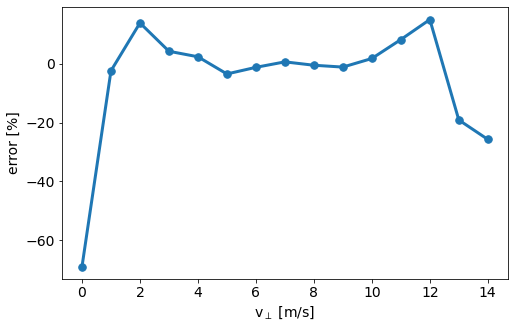

In [137]:
_t = h[1][:-1] + np.diff(h[1])[0]/2

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(100*(h[0] - norm.pdf(_t, mu, sigma))/h[0], '.-', ms = 15, lw = 3)

ax.set_ylabel('error [%]')
ax.set_xlabel(r'v$_\perp$ [m/s]')
set_fontsize(ax, 14)